In [ ]:
# -1 Install libraries


# osmnx
# networkx
# geopandas
# shapely
# numpy==1.23
# scipy
# netCDF4
# matplotlib
# torch>=2.7.0
# torch-geometric>=2.6.1
# scikit-learn>= 1.6.1

# pip install osmnx networkx geopandas "shapely" numpy==1.23 scipy netCDF4 matplotlib torch>=2.7.0 torch-geometric>=2.6.1 scikit-learn>=1.6.1

In [ ]:
# 0. Import necessary libraries

import numpy as np
import networkx as nx
import torch
from torch_geometric.nn import SAGEConv

import torch.nn.functional as F
import os
import geopandas as gpd
from shapely.geometry import Point
from scipy.spatial import cKDTree
import numpy as np
import osmnx as ox
import netCDF4 as nc
import matplotlib.pyplot as plt
import random
import gzip
import pickle
import json

from torch_geometric.data import Data

C:\Users\qshah\AppData\Local\Temp\ipykernel_18496\119901215.py:10: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


In [3]:
# 1. Define constants and load data
# Variables used for the backend

datafile = "chicago"
ymax = 41.895
ymin = 41.875
xmax = -87.62
xmin = -87.645
time = 17



origin = 41.88901939685322, -87.6443284831023
destination = 41.875623416440874, -87.6206305735239

BASE_PATH = "./data/weather/" # Path to weather data files

# How to visualize the map

# Time 1 - 48: 
# July 6, 2025 00:00 (midnight) - Time 1
# July 6, 2025 00:15 - Time 2
# ...

# Use this as the default weights. Then give user the option to change them.
# rain_weight = 0.85834
# heat_weight = 0.02850
# humidity_weight = 0.09648
# wind_weight = 0.01657

# Optimized: Shows 2 routes: quickest path and weather-optimized path for all weathers
# OD
# K_varaible_paths. Not required.
# rain_weight, heat_weight, wind_weight, humidity_weight: Weights for weather conditions. Sum should be 1.0
# So the higher the rain_weight... the more the route avoids rain.. the lower the rain_weight its more likely to take the quickest path and ignore rain

# weather_conditions: names of weather conditions to consider. Options are ["rain", "heat", "humidity", "wind"]
# weather_weights: weights for each weather condition in the same order as weather_conditions list
# time variable


# Variable: Shows K weather optimized paths plus the quickest path
# OD
# K_varaible_paths. 3/4/5.
# rain_weight/heat_weight/wind_weight/humidity_weight. Could be one or more weights. If we select rain and heat, then gives 3 paths: rain optimized, 3 paths: heat optimized + quickest path
# weather_conditions: names of weather conditions to consider. Options are ["rain", "heat", "humidity", "wind"]
# weather_weights: weights for each weather condition in the same order as weather_conditions list
# time variable: 

# Maps:
# Total must not exceed 1.
# We can see Rain, heat. ANd it will provide route for only rain, only heat, and also considering total of both rain and heat.
# And also provide the quickest path!!


map_view_mode = "Variable"
K_variable_paths = 3  # Only used if map_view_mode is "Variable"
# Weather conditions could be ["rain", "heat", "humidity", "wind", "total"]
weather_conditions = ["rain"]


# NOTE the sum of weights should be 1.0, the rest of the weight is given to the time path

# For example if you select Variable map view with K=2 and weather_conditions = ["rain"]
# and the rain weight is 85834, the weights to calculate the rain optimized path would be:
# Rain - 0.85834
# Time - 0.14166

# If you select Multiple map view with weather_conditions = ["rain", "heat"]
# the weights to calculate the total route would be:
# Rain - 0.85834
# Heat - 0.02850
# Time - 0.11316


rain_weight = 0.85834
heat_weight = 0.02850
humidity_weight = 0.09648
wind_weight = 0.01658


if abs(rain_weight + heat_weight + humidity_weight + wind_weight) > 1.0:
    raise ValueError("The sum of weather weights should be 1.0")




def load_NetCDF_data(data_path, variable_name):
    """
    Loads data from a NetCDF file and masks it to the specified lat/lon bounds.
    """
    if not os.path.exists(data_path):
        raise FileNotFoundError(f"Data file not found: {data_path}")
    ds = nc.Dataset(data_path)
    data = ds.variables[variable_name][time, :, :]
    lats = ds.variables['XLAT'][time, :, :]
    lons = ds.variables['XLONG'][time, :, :]

    mask = (lats >= ymin) & (lats <= ymax) & (lons >= xmin) & (lons <= xmax)
    data_masked = np.where(mask, data, np.nan)

    return data_masked, lats, lons, ds

def load_wind_data(wind_speed_path, wind_direction_path):
    """
    Loads wind speed and direction data from NetCDF files.
    """
    wspd, lats_w, lons_w, ds_wspd = load_NetCDF_data(wind_speed_path, 'WSPD10')
    wdir, _, _, ds_wdir = load_NetCDF_data(wind_direction_path, 'WDIR10')

    return wspd, wdir, lats_w, lons_w, ds_wspd, ds_wdir


rain_data, rain_lats, rain_lons, rain_ds = load_NetCDF_data(BASE_PATH + "RAIN.nc", 'RAIN')
heat_data, heat_index_lats, heat_index_lons, heat_ds = load_NetCDF_data(BASE_PATH + "T2.nc", 'T2')
humidity_data, humidity_lats, humidity_lons, humidity_ds = load_NetCDF_data(BASE_PATH + "RH2.nc", 'RH2')
wind_speed_data, wind_dir_data, wind_lats, wind_lons, wind_speed_ds, wind_dir_ds = load_wind_data(BASE_PATH + "WSPD10.nc", BASE_PATH + "WDIR10.nc")
print("Weather data loaded")

# Load Graph
with gzip.open("./data/%s/roads.pkl.gz" % datafile, "rb") as f:
    G = pickle.load(f)

nodes, _ = ox.graph_to_gdfs(G, nodes=True, edges=True, fill_edge_geometry=False)
mask = (
    (nodes["y"] <= ymax) & (nodes["y"] >= ymin) &
    (nodes["x"] <= xmax) & (nodes["x"] >= xmin)
)
node_ids = nodes.loc[mask].index
G_crop = G.subgraph(node_ids)

print("Graph loaded")

orig_node = ox.distance.nearest_nodes(G_crop, X=origin[1], Y=origin[0])
dest_node = ox.distance.nearest_nodes(G_crop, X=destination[1], Y=destination[0])
print("Origin and destination nodes found")


Weather data loaded
Graph loaded
Origin and destination nodes found


In [4]:
u, v, k, data = list(G_crop.edges(keys=True, data=True))[0]
print(f"From {u} to {v}, key {k}:")
print(data)

From 9504620579 to 2219227939, key 0:
{'access': None, 'area': None, 'bicycle': None, 'bicycle_road': None, 'bridge': None, 'busway': None, 'cycleway': None, 'foot': None, 'footway': None, 'highway': 'tertiary', 'junction': None, 'lanes': '2', 'lit': None, 'maxspeed': None, 'motorcar': None, 'motorroad': None, 'motor_vehicle': None, 'name': 'North Kingsbury Street', 'oneway': 'yes', 'psv': None, 'ref': None, 'service': None, 'segregated': None, 'sidewalk': None, 'smoothness': None, 'surface': 'asphalt', 'tracktype': None, 'tunnel': None, 'turn': None, 'width': None, 'id': 1031144476, 'timestamp': 1755506724, 'version': 12, 'tags': '{"visible":false,"cycleway:both":"no","sidewalk:both":"separate","turn:lanes":"left|right"}', 'osm_type': 'way', 'geometry': <LINESTRING (-87.638 41.889, -87.638 41.889)>, 'length': 0.848, 'speed_kph': 43.3, 'travel_time': 0.1}


In [5]:
# 2. Calculate isochrones
def get_estimated_ETA(G, route):
    """
    Obtains estimated ETA from a calculated route.
    Parameters:
    route (list): List of node IDs representing the route.
    
    Returns:
    List: A list of 15 minute segments until the total travel time in seconds.

    Example:
    [15, 30, 45, 60] for a 1 hour trip.
    
    """
    # Get travel time in seconds
    total_time_sec = sum(
        G[u][v][0]['time']
        for u, v in zip(route[:-1], route[1:])
    )
    
    #Create 15 minute segments
    trip_times = list(range(15, int(total_time_sec // 60) + 15, 15))
    
    
    return trip_times

def calculate_isochrones(G, orig, route):
    """
    This function calculates isochrones for a given graph G and origin node.
    It assigns a 'zone' attribute to each edge in the graph based on travel time segments
    
    Later this different zones will be used to stitch different weather datasets times together.
    """
    for u, v, k, data in G.edges(data=True, keys=True):
        
        # Add a tag for zone
        data['zone'] = 0
        data['time'] = data['length'] / (data['speed_kph'] * 1000 / 3600)
        
    travel_times = get_estimated_ETA(G, route)
    trip_times_seconds = [t * 60 for t in travel_times]
    for zone_num, trip_time in enumerate(sorted(trip_times_seconds), start=1):
        subgraph = nx.ego_graph(G, orig, radius=trip_time, distance='time')
        for u, v, k in subgraph.edges(keys=True):
            if G.has_edge(u, v, k) and G[u][v][k]["zone"] == 0:
                G[u][v][k]["zone"] = zone_num
        
    return trip_times_seconds

route = nx.shortest_path(G_crop, orig_node, dest_node, weight="travel_time")
trip_times_seconds = calculate_isochrones(G_crop, orig_node, route)

print("zones calculated")


zones calculated


In [ ]:
# 3. Define the GNN model

class NodeRegressor(torch.nn.Module):
    
    """
    Simple GraphSAGE-based regressor for node-level prediction of weather variables.
    """
    
    def __init__(self, in_channels, hidden_channels, out_channels=5):
        super().__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.lin = torch.nn.Linear(hidden_channels, out_channels)
        

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        out = self.lin(x)
        return out


def classic_weight_calculations(
    G, lats, lons, rain_ds, time, heat_ds, wind_speed_ds, wind_dir_ds, humidity_ds,
    rain_weight=0.85834, heat_weight=0.02850,
    wind_weight=0.09648, humidity_weight=0.01668
) -> None:
    """
    Apply weather-based penalties to edge weights in the graph according to
    
    This method iterates trough each edge and calculates weights based on weather data and zone.
    
    Default penalty lambda based calculated previously with entropy weights.
    rain_weight: 0.85834
    heat_weight: 0.02850
    wind_weight: 0.09648
    rh_weight: 0.01668
    
    """
    calculated_zones = []

    print("Calculating weights with classic method")

    for u, v, k, data in G.edges(keys=True, data=True):
        y1, x1 = G.nodes[u]['y'], G.nodes[u]['x']
        y2, x2 = G.nodes[v]['y'], G.nodes[v]['x']
        lat, lon = (y1 + y2) / 2, (x1 + x2) / 2

        t_uv = data.get("travel_time", 1)

        r_term = w_term = tau_term = h_term = 0


        # If rain is selected as a weight, calculate rain penalty
        if (rain_ds is not None) and (rain_weight is not None):
            rain = rain_ds.variables['RAIN'][time + G[u][v][k]["zone"], :, :]
            if G[u][v][k]["zone"] not in calculated_zones:
                calculated_zones.append(G[u][v][k]["zone"])
            rain_mm = get_element_at_point(lat, lon, rain, lats, lons)
            
            r_term = (rain_weight * rain_mm + t_uv * (1 - rain_weight))
            data['rain_weight'] = r_term

        # If heat index is selected as a weight, calculate heat penalty
        if (heat_ds is not None) and (heat_weight is not None):
            heat_index = heat_ds.variables['T2'][time + data['zone'] - 1, :, :]
            heat_at_point = get_element_at_point(lat, lon, heat_index, lats, lons)
            tau_term = (heat_weight * heat_at_point + t_uv * (1 - heat_weight))
            data['heat_weight'] = tau_term

        # If humidity is selected as a weight, calculate humidity penalty
        if (humidity_ds is not None) and (humidity_weight is not None):
            relative_humidity = humidity_ds.variables['RH2'][time + data['zone'] - 1, :, :]
            rh_at_point = get_element_at_point(lat, lon, relative_humidity, lats, lons)
            h_term = (humidity_weight * rh_at_point + t_uv * (1 - humidity_weight))
            data['humidity_weight'] = h_term

        # If wind is selected as a weight, calculate wind penalty
        if (wind_dir_ds is not None) and (wind_speed_ds is not None) and (wind_weight is not None):
            wind_speed = wind_speed_ds.variables['WSPD10'][time + data['zone'] - 1, :, :]
            wind_direction = wind_dir_ds.variables['WDIR10'][time + data['zone'] - 1, :, :]

            wind_spd_at_point = get_element_at_point(lat, lon, wind_speed, lats, lons)
            wind_dir_at_point = get_element_at_point(lat, lon, wind_direction, lats, lons)

            # This is faster than computing sin/cos each time
            sin_lut = np.sin(np.radians(np.arange(360)))
            cos_lut = np.cos(np.radians(np.arange(360)))

            crosswind = wind_spd_at_point * sin_lut[int(wind_dir_at_point) % 360]
            headwind = wind_spd_at_point * cos_lut[int(wind_dir_at_point) % 360]

            w_term = (wind_weight * (abs(crosswind) + max(0, headwind)) + t_uv * (1 - wind_weight))
            data['wind_weight'] = w_term

        
        data['total_weight'] = t_uv * (1 + r_term + w_term + tau_term + h_term)


def build_grid_kdtree(lats_arr, lons_arr):
    """Builds a k-d tree from flattened grid coordinates for fast nearest-neighbor lookup."""
    grid_points = np.vstack((lats_arr.flatten(), lons_arr.flatten())).T
    return cKDTree(grid_points)


def get_values_at_points_kdtree(grid_vals, kdtree, points_latlon):
    """Gets weather values from a grid for specific points using a pre-built k-d tree."""
    _, indices = kdtree.query(points_latlon, k=1)
    flat_vals = grid_vals.flatten()
    return flat_vals[indices]


def GNN_weight_calculations(G, 
                            lats, 
                            lons, 
                            rain_ds,
                            rain_data, 
                            time, 
                            heat_ds, 
                            heat_data, 
                            wind_speed_ds, 
                            wind_speed_data, 
                            wind_dir_ds, 
                            wind_dir_data, 
                            humidity_ds, 
                            humidity_data, 
                            trip_time_seconds, 
                            rain_weight= 0.85834, 
                            heat_weight=0.02850, 
                            wind_weight=0.09648, 
                            humidity_weight=0.01668) -> None:
    """
    Use a GNN to predict rain in any given node and use that vector to apply weights to the graph edges as a matrix operation.

    This modifies the weights for travel_time into a new variable "rain_weight", so that the routing algorithm can optimize for the fastest route given current weather events.

    Parameters:
    G (networkx.MultiDiGraph): The street graph.
    rain_ds (NC): 3D array of rain data (time, lat, lon).
    heat_ds (NC): 3D array of heat data (time, lat, lon).
    wind_speed_ds (NC): 3D array of wind speed data (time, lat, lon).
    wind_dir_ds (NC): 3D array of wind direction data (time, lat, lon).
    humidity_ds (NC): 3D array of humidity data (time, lat, lon).
    rain_data (np.ndarray): Raw rain data for training.
    heat_data (np.ndarray): Raw heat data for training.
    wind_speed_data (np.ndarray): Raw wind speed data for training.
    wind_dir_data (np.ndarray): Raw wind direction data for training.
    humidity_data (np.ndarray): Raw humidity data for training.
    time (int): Starting time index for weather data.
    trip_time_seconds (list): List of trip times in seconds for which to stitch datasets.
    lats (np.ndarray): 2D array of latitudes corresponding to the rain data
    lons (np.ndarray): 2D array of longitudes corresponding to the rain data
    rain_penalty_lambda (float): Scaling factor for rain penalty.

    Default penalty lambda based calculated previously with entropy weights.
    rain_weight: 0.85834
    heat_weight: 0.02850
    wind_weight: 0.09648
    rh_weight: 0.01668

    """

    print("Stitching datasets")
    rain_stitched = stitchDataset(G, rain_ds, starting_time=time, trip_time_seconds=trip_time_seconds, variable_name='RAIN')
    heat_stitched = stitchDataset(G, heat_ds, starting_time=time, trip_time_seconds=trip_time_seconds, variable_name='T2')
    wind_speed_stitched = stitchDataset(G, wind_speed_ds, starting_time=time, trip_time_seconds=trip_time_seconds, variable_name='WSPD10')
    wind_dir_stitched = stitchDataset(G, wind_dir_ds, starting_time=time, trip_time_seconds=trip_time_seconds, variable_name='WDIR10')
    humidity_stitched = stitchDataset(G, humidity_ds, starting_time=time, trip_time_seconds=trip_time_seconds, variable_name='RH2')
    print("Datasets Stitched")
    
    # Extract 2D spatial grids
    lats_raw = rain_ds.variables['XLAT'][:]
    lons_raw = rain_ds.variables['XLONG'][:]
    if lats_raw.ndim == 3:
        lats_2d = np.array(lats_raw[0, :, :])
        lons_2d = np.array(lons_raw[0, :, :])
    else:
        lats_2d = np.array(lats_raw)
        lons_2d = np.array(lons_raw)
        
    node_ids = list(G.nodes)
    coords = np.array([[G.nodes[n]['y'], G.nodes[n]['x']] for n in node_ids])  # lat, lon
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    print("Preparing node features and edges")
    # We build our variables to input to the GNN
    x, edge_index, node_ids = prepare_node_features_and_edges(
        G, rain_stitched, heat_stitched, wind_speed_stitched, wind_dir_stitched, humidity_stitched,
        lats_2d, lons_2d, coords
    )
    x = x.to(device)
    edge_index = edge_index.to(device)


    # if os.path.exists("GNN_model.pth"): # Pre trained model included in repo
    #     model = NodeRegressor(x.shape[1], hidden_channels=64).to(device)
    #     checkpoint = torch.load("GNN_model.pth", map_location=device)
    #     model.load_state_dict(checkpoint['model_state_dict'])
    #     print("Loaded trained GNN model.")
    # else:
    #     model = train_GNN_model(G, rain_data, heat_data, wind_speed_data, wind_dir_data, humidity_data, coords, node_ids, lons, lats)
    #     print("Trained new GNN model.")
    #     model = model.to(device)

    # # Model makes predictions
    # model.eval()
    # with torch.no_grad():
    #     preds = model(x, edge_index).cpu().numpy()
    # preds = np.nan_to_num(preds, nan=0.0)
   
    # rain_pred_node = np.clip(preds[:, 0], 0, None)
    # heat_pred_node = preds[:, 1]
    # humidity_pred_node = np.clip(preds[:, 2], 0, 1)  
    # wind_speed_pred_node = np.clip(preds[:, 3], 0, None)
    # wind_dir_pred_node = preds[:, 4]  # allow negative for direction


    
    
    # # Vectorized edge weight assignment
    # id_to_idx = {nid: i for i, nid in enumerate(node_ids)}
    # edges_list = list(G.edges(keys=True))
    # u_idx = np.array([id_to_idx[u] for u, _, _ in edges_list])
    # v_idx = np.array([id_to_idx[v] for _, v, _ in edges_list])

    # # Base edge lengths
    # travel_lengths = []
    # for u, v, k in edges_list:
    #     data = G.get_edge_data(u, v)
    #     if isinstance(data, dict):
    #         k0 = list(data.keys())[0]
    #         d = data[k0]
    #     else:
    #         d = data
    #     travel_lengths.append(d.get("travel_time", 1.0))
    # travel_lengths = np.array(travel_lengths, dtype=np.float32)

    # # Create edge index
    # id_to_idx = {nid: i for i, nid in enumerate(node_ids)}
    # edges_list = list(G.edges(keys=True))
    # u_idx = np.array([id_to_idx[u] for u, _, _ in edges_list])
    # v_idx = np.array([id_to_idx[v] for _, v, _ in edges_list])

    # travel_lengths = np.array([G[u][v][k].get("travel_time", 1.0) for u, v, k in edges_list], dtype=np.float32)

    # # Get predicted weather values at edge target nodes
    # rain_pred_at_v = rain_pred_node[v_idx]
    # heat_pred_at_v = heat_pred_node[v_idx]
    # humidity_pred_at_v = humidity_pred_node[v_idx]
    # wind_speed_pred_at_v = wind_speed_pred_node[v_idx]
    # wind_dir_pred_at_v = wind_dir_pred_node[v_idx]

    # # Calculate all edge weights in a vectorized manner
    # rain_w = abs((rain_pred_at_v * rain_weight) + (travel_lengths * (1 - rain_weight)))
    # heat_w = abs((heat_pred_at_v * heat_weight) + (travel_lengths * (1 - heat_weight)))
    # humidity_w = abs((humidity_pred_at_v * humidity_weight) + (travel_lengths * (1 - humidity_weight)))
    # wind_w = abs((wind_speed_pred_at_v * wind_weight) + (travel_lengths * (1 - wind_weight)))
    # wind_dir_w = (wind_dir_pred_at_v * wind_weight) + (travel_lengths * (1 - wind_weight))

    # total_w = (
    #     (rain_weight * rain_pred_at_v) +
    #     (wind_weight * wind_speed_pred_at_v) +
    #     (heat_weight * heat_pred_at_v) +
    #     (humidity_weight * humidity_pred_at_v) +
    #     (travel_lengths * (1 - (rain_weight + wind_weight + heat_weight + humidity_weight)))
    # )

    # rain_weights_dict = dict(zip(edges_list, rain_w))
    # heat_weights_dict = dict(zip(edges_list, heat_w))
    # humidity_weights_dict = dict(zip(edges_list, humidity_w))
    # wind_weights_dict = dict(zip(edges_list, wind_w))
    # wind_dir_weights_dict = dict(zip(edges_list, wind_dir_w))
    # total_weights_dict = dict(zip(edges_list, total_w))

    # # Perform bulk assignment of the new weights to the graph edges
    # nx.set_edge_attributes(G, rain_weights_dict, "rain_weight")
    # nx.set_edge_attributes(G, heat_weights_dict, "heat_weight")
    # nx.set_edge_attributes(G, humidity_weights_dict, "humidity_weight")
    # nx.set_edge_attributes(G, wind_weights_dict, "wind_weight")
    # nx.set_edge_attributes(G, wind_dir_weights_dict, "wind_dir_weight")
    # nx.set_edge_attributes(G, total_weights_dict, "total_weight")
    
    # print("Edge weights computed.")


def get_element_at_point(lat, lon, rain_grid, lats, lons):
    """Get the rain value at a specific lat/lon point from the rain grid."""
    i = np.argmin(np.abs(lats[:, 0] - lat))
    j = np.argmin(np.abs(lons[0, :] - lon))
    return rain_grid[i, j]


def train_GNN_model(G, rain_grid, heat_grid, wind_speed_grid, wind_dir_grid, humidity_grid, coords, node_ids, lons, lats, hidden_dim=64, lr=1e-3, epochs=300, out_channels=5):
    """
    Trains a GNN model to predict weather variables at graph nodes.
    When trained first time, the training data is the same as the input data.
    """
    
    
    grid_kdtree = build_grid_kdtree(lats, lons)

    rain_nodes = get_values_at_points_kdtree(rain_grid, grid_kdtree, coords)
    rain_nodes = np.nan_to_num(rain_nodes, nan=np.nanmedian(rain_nodes))
    
    heat_nodes = get_values_at_points_kdtree(heat_grid, grid_kdtree, coords)
    heat_nodes = np.nan_to_num(heat_nodes, nan=np.nanmedian(heat_nodes))
    
    wind_speed_nodes = get_values_at_points_kdtree(wind_speed_grid, grid_kdtree, coords)
    wind_speed_nodes = np.nan_to_num(wind_speed_nodes, nan=np.nanmedian(wind_speed_nodes))
    
    wind_dir_nodes = get_values_at_points_kdtree(wind_dir_grid, grid_kdtree, coords)
    wind_dir_nodes = np.nan_to_num(wind_dir_nodes, nan=np.nanmedian(wind_dir_nodes))
    
    humidity_nodes = get_values_at_points_kdtree(humidity_grid, grid_kdtree, coords)
    humidity_nodes = np.nan_to_num(humidity_nodes, nan=np.nanmedian(humidity_nodes))
    
    # Build edge_index
    id_to_idx = {nid: i for i, nid in enumerate(node_ids)}
    edges = []
    for u_n, v_n, data in G.edges(data=True):
        edges.append([id_to_idx[u_n], id_to_idx[v_n]])
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    
    if edge_index.numel() == 0:
        raise RuntimeError("Edge index is empty!")

    x_np = np.column_stack([
        coords[:, 0],  # lat
        coords[:, 1],  # lon
        rain_nodes,
        heat_nodes,
        wind_speed_nodes,
        wind_dir_nodes,
        humidity_nodes,
    ])
    x = torch.tensor(x_np, dtype=torch.float)

    y_np = np.column_stack([
        rain_nodes,
        heat_nodes,
        humidity_nodes,
        wind_speed_nodes,
        wind_dir_nodes,
    ])
    y = torch.tensor(y_np, dtype=torch.float)

    data = Data(x=x, edge_index=edge_index, y=y)

    # Simple train/val split: random nodes (since we treat each node as sample)
    num_nodes = data.num_nodes
    perm = np.random.permutation(num_nodes)
    train_n = int(0.8 * num_nodes)
    train_idx = torch.tensor(perm[:train_n], dtype=torch.long)
    val_idx = torch.tensor(perm[train_n:], dtype=torch.long)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
    
    model = NodeRegressor(in_channels=data.num_node_features, hidden_channels=hidden_dim, out_channels=out_channels).to(device)
    data = data.to(device)
    in_ch = data.num_node_features
    out_ch = data.y.shape[1]  

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = torch.nn.MSELoss()
    
    for epoch in range(1, epochs + 1):
        model.train()
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = loss_fn(out[train_idx], data.y[train_idx])
        loss.backward()
        optimizer.step()

        if epoch % 20 == 0 or epoch==1:
            model.eval()
            with torch.no_grad():
                val_out = model(data.x, data.edge_index)
                val_loss = loss_fn(val_out[val_idx], data.y[val_idx])
            print(f"Epoch {epoch:04d} train_loss={loss.item():.6f} val_loss={val_loss.item():.6f}")

    model_path = "GNN_model.pth"
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch,
        'train_idx': train_idx,
        'val_idx': val_idx,
        'in_channels': in_ch,
        'out_channels': out_ch,
    }, model_path)
    return model



def prepare_node_features_and_edges(G, rain_grid, heat_grid, wind_speed_grid, wind_dir_grid, humidity_grid, lats, lons, coords):

    grid_kdtree = build_grid_kdtree(lats, lons)
    
    node_ids = list(G.nodes)


    if rain_grid is not None: 
        rain_nodes = get_values_at_points_kdtree(rain_grid, grid_kdtree, coords)
        rain_nodes = np.nan_to_num(rain_nodes, nan=np.nanmedian(rain_nodes))
    else:
        rain_nodes = np.zeros(len(coords))

    if heat_grid is not None:
        heat_nodes = get_values_at_points_kdtree(heat_grid, grid_kdtree, coords)
        heat_nodes = np.nan_to_num(heat_nodes, nan=np.nanmedian(heat_nodes))
    else:
        heat_nodes = np.zeros(len(coords))

    if wind_speed_grid is not None:
        wind_speed_nodes = get_values_at_points_kdtree(wind_speed_grid, grid_kdtree, coords)
        wind_speed_nodes = np.nan_to_num(wind_speed_nodes, nan=np.nanmedian(wind_speed_nodes))
    else:
        wind_speed_nodes = np.zeros(len(coords))

    if wind_dir_grid is not None:
        wind_dir_nodes = get_values_at_points_kdtree(wind_dir_grid, grid_kdtree, coords)
        wind_dir_nodes = np.nan_to_num(wind_dir_nodes, nan=np.nanmedian(wind_dir_nodes))
    else:
        wind_dir_nodes = np.zeros(len(coords))

    if humidity_grid is not None:
        humidity_nodes = get_values_at_points_kdtree(humidity_grid, grid_kdtree, coords)
        humidity_nodes = np.nan_to_num(humidity_nodes, nan=np.nanmedian(humidity_nodes))
    else:
        humidity_nodes = np.zeros(len(coords))
    
    # Node features (lat, lon, and weather data)
    x_np = np.column_stack([
        coords[:, 0],
        coords[:, 1],
        rain_nodes,
        heat_nodes,
        wind_speed_nodes,
        wind_dir_nodes,
        humidity_nodes,
    ])
    x = torch.tensor(x_np, dtype=torch.float)

    # Build edge_index
    id_to_idx = {nid: i for i, nid in enumerate(node_ids)}
    edges = []
    for u_n, v_n, data in G.edges(data=True):
        edges.append([id_to_idx[u_n], id_to_idx[v_n]])
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    if edge_index.numel() == 0:
        raise RuntimeError("Edge index is empty!")
    
    return x, edge_index, node_ids


def stitchDataset(G, dataset, trip_time_seconds, variable_name, starting_time=17):
    """Stitch together time slices from a dataset based on zones in the graph G."""
    import numpy as np
    
    # Preload time slices
    tdim = dataset.variables[variable_name].shape[0]
    loaded_data = []
    for t in range(len(trip_time_seconds)):
        idx = min(starting_time + t, tdim - 1)
        slice_data = np.array(dataset.variables[variable_name][idx, :, :])
        loaded_data.append(slice_data)

    zone_polygons = create_zone_polygons(G)

    # Extract 2D spatial grids
    lats_raw = dataset.variables['XLAT'][:]
    lons_raw = dataset.variables['XLONG'][:]
    
    if lats_raw.ndim == 3:
        lats = np.array(lats_raw[0, :, :])
        lons = np.array(lons_raw[0, :, :])
    else:
        lats = np.array(lats_raw)
        lons = np.array(lons_raw)

    stitched = np.zeros_like(loaded_data[0], dtype=np.float32)

    # Assign each zone its corresponding time slice
    for zone, polygon in zone_polygons.items():
        minx, miny, maxx, maxy = polygon.bounds
        zone_mask = (lats >= miny) & (lats <= maxy) & (lons >= minx) & (lons <= maxx)
        
        if not np.any(zone_mask):
            continue
        
        time_index = zone - 1
        if time_index < 0 or time_index >= len(loaded_data):
            continue
        
        stitched[zone_mask] = loaded_data[time_index][zone_mask]

    return stitched
    
def create_zone_polygons(G):
    """Create a convex hull polygon for each zone based on edge endpoints."""
    zones = {}
    for u, v, k, data in G.edges(keys=True, data=True):
        zone = data.get("zone", 0)
        if zone == 0:
            continue
        zones.setdefault(zone, []).append(Point(G.nodes[u]["x"], G.nodes[u]["y"]))
        zones.setdefault(zone, []).append(Point(G.nodes[v]["x"], G.nodes[v]["y"]))

    zone_polygons = {}
    for zone, points in zones.items():
        unique_pts = list({(p.x, p.y): p for p in points}.values())
        if len(unique_pts) >= 3:
            zone_polygons[zone] = gpd.GeoSeries(unique_pts).unary_union.convex_hull
        elif len(unique_pts) == 2:
            zone_polygons[zone] = gpd.GeoSeries(unique_pts).unary_union.buffer(0.001)
        elif len(unique_pts) == 1:
            zone_polygons[zone] = unique_pts[0].buffer(0.001)
    return zone_polygons

print("functions defined")


functions defined


In [7]:
# 3.1 Call the GNN weight calculation function

# Currently this only modifues G_crop, the route is calculated based on the modified G_crop
GNN_weight_calculations(G_crop, rain_lats, rain_lons,
                    rain_ds=rain_ds,
                    heat_ds=heat_ds,
                    wind_speed_ds=wind_speed_ds,
                    wind_dir_ds=wind_dir_ds,
                    humidity_ds=humidity_ds,
                    rain_data=rain_data,
                    heat_data=heat_data,
                    wind_speed_data=wind_speed_data,
                    wind_dir_data=wind_dir_data,
                    humidity_data=humidity_data,
                    time=time,
                    trip_time_seconds=trip_times_seconds,
                    rain_weight=rain_weight,
                    heat_weight=heat_weight,
                    wind_weight=wind_weight,
                    humidity_weight=humidity_weight
                )



Stitching datasets
Datasets Stitched
Preparing node features and edges


Calculating route optimized for rain...
[258022670, 9169043220, 12056499963, 12056499962, 9995480738, 708314133, 9995480736, 11670720876, 9678439397, 9169097247, 9169097253, 9169097276, 9995480729, 9169097252, 9169097270, 9169097269, 9169097248, 9169097251, 9995480731, 9169097278, 9169097245, 2235649599, 11670720878, 12056499961, 10942616789, 10942616788, 9995480726, 11851144361, 11670720877, 11851176739, 708328990, 11851144339, 11851144343, 11851144335, 2235649600, 9995470795, 258022686, 9995470797, 11842104516, 8623745772, 11114679386, 1980603236, 619626337, 1980603234, 11842104498, 11842060359, 296374736, 11842060360, 11842104567, 12599000546, 1980587868, 258022688, 6932804428, 6991264633, 11835824746, 7342370252, 619626669, 9658353949, 619625983, 6991264678, 11835824794, 3229401820, 11835824799, 6991264677, 6991303041, 1536858520, 1536858516, 6991303044, 4334600810, 6991303047, 12314025358, 12314025359, 6991303102, 9913426041, 28358938, 3725931608, 4334600809, 3725931609, 228433177

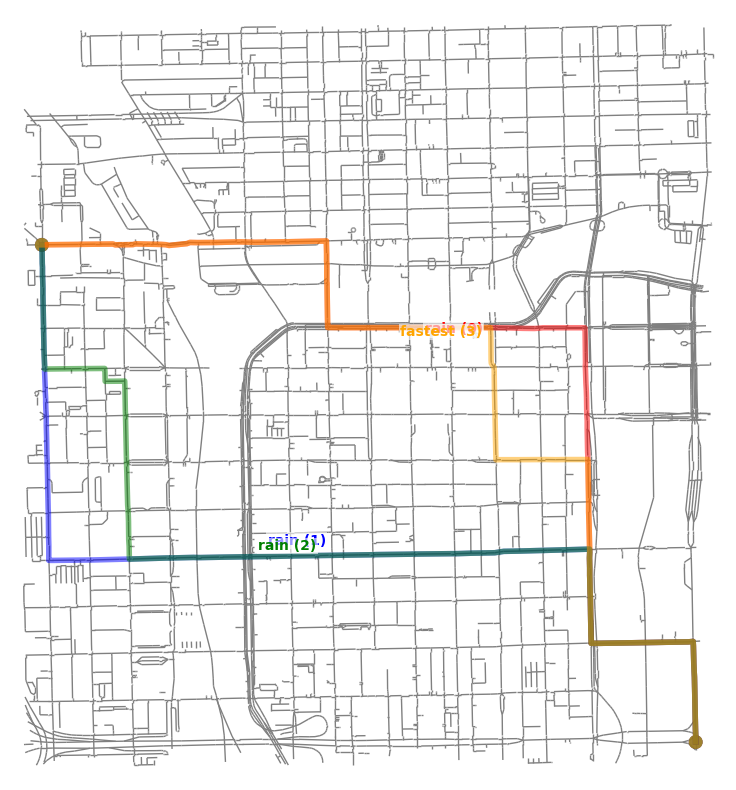

In [11]:

# How to visualize the map
# Optimized: Shows 2 routes: quickest path and weather-optimized path for all weathers
# Multiple: Shows a route for each weather condition in addition to the quickest path
# Maps: Shows a map per weather condition with the corresponding route overlaid
# Variable: Shows K weather optimized paths plus the quickest path 
map_view_mode = "Variable"
K_variable_paths = 3  # Only used if map_view_mode is "Variable"
# Weather conditions could be ["rain", "heat_index", "humidity", "wind_speed", "total"]
weather_conditions = ["rain"]

routes_data = []

if map_view_mode == "Optimized":
    fig, ax = plt.subplots(figsize=(10, 10))
    
    ox.plot_graph(G_crop, ax=ax, node_size=0, edge_color='gray', edge_linewidth=1, show=False, close=False)
    
    route_fastest = nx.shortest_path(G_crop, orig_node, dest_node, weight="travel_time")
    route_total = nx.shortest_path(G_crop, orig_node, dest_node, weight="total_weight")
    routes_data.append({
                    'route': route_fastest,
                    'weight_type': "quickest_path",
                    'route_index': 0
                })
    routes_data.append({
                    'route': route_total,
                    'weight_type': "total_weight",
                    'route_index': 1
                })
    
    color_map = ["black", "blue"]
    
    
    ox.plot_graph_routes(
        G_crop,
        routes=[rd['route'] for rd in routes_data],
        route_colors=[color_map[i] for i in range(len(routes_data))],
        route_linewidth=3,
        node_size=0,
        ax=ax,
        show=False,
        close=False
    )

    for i, rd in enumerate(routes_data):
        route = rd["route"]
        weight_type = rd["weight_type"]
    
        # Get coordinates for this route
        x, y = zip(*[(G_crop.nodes[n]['x'], G_crop.nodes[n]['y']) for n in route])
    
        # Midpoint (roughly)
        mid_idx = len(x) // 2
        x_mid, y_mid = x[mid_idx], y[mid_idx]
    
        offset_x = random.uniform(-0.001, 0.001)
        offset_y = random.uniform(-0.001, 0.001)
        
        ax.text(
            x_mid + offset_x,
            y_mid + offset_y,
            f"{weight_type} ({i})",
            fontsize=10,
            color=color_map[i % len(color_map)],
            weight="bold",
            bbox=dict(facecolor='white', edgecolor='none', alpha=0.6, pad=1)
        )

elif map_view_mode == "Variable":

    # For future reference, the k_shortest_paths and shortest_paths are the ones that acually return a list of osm ID's
    for weight in weather_conditions:
        # calculate route optimized for every selected weight
        try:
            print(f"Calculating route optimized for {weight}...")
            # Use Yen's algorithm for k-shortest paths
            k_paths = list(ox.routing.k_shortest_paths(G_crop, orig_node, dest_node, k=(K_variable_paths), weight=f"{weight}_weight"))
                    
            # Add each route to routes_data which will be processed later
            for i in range(K_variable_paths):
                route = k_paths[i]
                routes_data.append({
                    'route': route,
                    'weight_type': weight,
                    'route_index': i
                })
                
        except Exception as e:
            print(f"Could not calculate route for {weight}: {e}")
                
    route_fastest = nx.shortest_path(G_crop, orig_node, dest_node, weight="travel_time")
    routes_data.append({
        'route': route_fastest,
        'weight_type': 'fastest',
    })

    print(route_fastest)


    route_coords = []
    for node_id in route_fastest:
        node = G_crop.nodes[node_id]
        route_coords.append((node['y'], node['x']))

    print(route_coords)


    output_filename = "route.json"
    
    with open(output_filename, "w") as f:
        json.dump(route_coords, f, indent=4)
    
    # Its possible to obtain route metrics like this:
    # fastest_distance = nx.path_weight(G_crop, route_fastest, weight='length') / 1000
    # fastest_duration = nx.path_weight(G_crop, route_fastest, weight='travel_time') / 60
    # fastest_rain = nx.path_weight(G_crop, route_fastest, weight='rain_weight') if 'rain' in selected_weights else 0
    # fastest_heat = nx.path_weight(G_crop, route_fastest, weight='heat_weight') if 'heat' in selected_weights else 0
    # fastest_wind = nx.path_weight(G_crop, route_fastest, weight='wind_weight') if 'wind' in selected_weights else 0
    # fastest_humidity = nx.path_weight(G_crop, route_fastest, weight='humidity_weight') if 'humidity' in selected_weights else 0
    
    
    
    print("Routes calculated and ready for visualization.")

    
    fig, ax = plt.subplots(figsize=(10, 10))
    
    ox.plot_graph(G_crop, ax=ax, node_size=0, edge_color='gray', edge_linewidth=1, show=False, close=False)
    
    color_map = ["red", "blue", "green", "orange", "purple", "brown", "pink", "gray"]
    
    ox.plot_graph_routes(
        G_crop,
        routes=[rd['route'] for rd in routes_data],
        route_colors=[color_map[i] for i in range(len(routes_data))],
        route_linewidth=3,
        node_size=0,
        ax=ax,
        show=False,
        close=False
    )
    for i, rd in enumerate(routes_data):
        route = rd["route"]
        weight_type = rd["weight_type"]
    
        # Get coordinates for this route
        x, y = zip(*[(G_crop.nodes[n]['x'], G_crop.nodes[n]['y']) for n in route])
    
        # Midpoint (roughly)
        mid_idx = len(x) // 2
        x_mid, y_mid = x[mid_idx], y[mid_idx]
    
        offset_x = random.uniform(-0.001, 0.001)
        offset_y = random.uniform(-0.001, 0.001)
        
        ax.text(
            x_mid + offset_x,
            y_mid + offset_y,
            f"{weight_type} ({i})",
            fontsize=10,
            color=color_map[i % len(color_map)],
            weight="bold",
            bbox=dict(facecolor='white', edgecolor='none', alpha=0.6, pad=1)
        )

elif map_view_mode == "Maps": 
    
    # For future reference, the k_shortest_paths and shortest_paths are the ones that acually return a list of osm ID's
    for weight in weather_conditions:
        # calculate route optimized for every selected weight
        try:
            print(f"Calculating route optimized for {weight}...")
            # Use Yen's algorithm for k-shortest paths
            route = nx.shortest_path(G_crop, orig_node, dest_node, weight=f"{weight}_weight")
                    
            # Add each route to routes_data which will be processed later
    
            routes_data.append({
                'route': route,
                'weight_type': weight,
            })
            
        except Exception as e:
            print(f"Could not calculate route for {weight}: {e}")
                
    route_fastest = nx.shortest_path(G_crop, orig_node, dest_node, weight="travel_time")
    routes_data.append({
        'route': route_fastest,
        'weight_type': 'fastest',
    })

    
    print("Routes calculated and ready for visualization.")
    
    for i, rd in enumerate(routes_data):
        fig, ax = plt.subplots(figsize=(10, 10))
        
        # Plot base graph
        ox.plot_graph(G_crop, ax=ax, node_size=0, edge_color='gray', edge_linewidth=1, show=False, close=False)
        
        # Plot the route
        ox.plot_graph_route(
            G_crop,
            route=rd['route'],
            route_color='red',
            route_linewidth=3,
            node_size=0,
            ax=ax,
            show=False,
            close=False
        )
        
        # Add title
        ax.set_title(f"Route optimized for: {rd['weight_type']}", fontsize=14, fontweight='bold')
        
        # Add route label at midpoint
        route = rd['route']
        x, y = zip(*[(G_crop.nodes[n]['x'], G_crop.nodes[n]['y']) for n in route])
        mid_idx = len(x) // 2
        x_mid, y_mid = x[mid_idx], y[mid_idx]
        
        ax.text(
            x_mid,
            y_mid,
            f"{rd['weight_type']}",
            fontsize=12,
            color='red',
            weight="bold",
            bbox=dict(facecolor='white', edgecolor='red', alpha=0.8, pad=3)
        )
    
elif map_view_mode == "Multiple": 
    
    for weight in weather_conditions:
        # calculate route optimized for every selected weight
        try:
            print(f"Calculating route optimized for {weight}...")
            # Use Yen's algorithm for k-shortest paths
            route = nx.shortest_path(G_crop, orig_node, dest_node, weight=f"{weight}_weight")
                    
            # Add each route to routes_data which will be processed later
    
            routes_data.append({
                'route': route,
                'weight_type': weight,
            })
            
        except Exception as e:
            print(f"Could not calculate route for {weight}: {e}")
                
    route_fastest = nx.shortest_path(G_crop, orig_node, dest_node, weight="travel_time")
    routes_data.append({
        'route': route_fastest,
        'weight_type': 'fastest',
    })

    print(route_fastest)
    
    print("Routes calculated and ready for visualization.")

    fig, ax = plt.subplots(figsize=(10, 10))
    
    ox.plot_graph(G_crop, ax=ax, node_size=0, edge_color='gray', edge_linewidth=1, show=False, close=False)
    
    color_map = ["red", "blue", "green", "orange", "purple", "brown", "pink", "gray"]
    
    ox.plot_graph_routes(
        G_crop,
        routes=[rd['route'] for rd in routes_data],
        route_colors=[color_map[i] for i in range(len(routes_data))],
        route_linewidth=3,
        node_size=0,
        ax=ax,
        show=False,
        close=False
    )
    for i, rd in enumerate(routes_data):
        route = rd["route"]
        weight_type = rd["weight_type"]
    
        # Get coordinates for this route
        x, y = zip(*[(G_crop.nodes[n]['x'], G_crop.nodes[n]['y']) for n in route])
    
        # Midpoint (roughly)
        mid_idx = len(x) // 2
        x_mid, y_mid = x[mid_idx], y[mid_idx]
    
        offset_x = random.uniform(-0.001, 0.001)
        offset_y = random.uniform(-0.001, 0.001)
        
        ax.text(
            x_mid + offset_x,
            y_mid + offset_y,
            f"{weight_type} ({i})",
            fontsize=10,
            color=color_map[i % len(color_map)],
            weight="bold",
            bbox=dict(facecolor='white', edgecolor='none', alpha=0.6, pad=1)
        )

plt.show()

In [ ]:
from weather_routing import calculate_weather_route

In [ ]:
city = 'chicago'
input = 'baselayer-0'

calculate_weather_route(city,
                        input,
                        {'lat': 41.884573, 'lon': -87.652446} ,
                        {'lat': 41.889618, 'lon': -87.622991},
                        mode = 'Default weights',
                        K = 1,
                        time_ = "2025-07-06T00:00:00",
                        rain = 0.85834,
                        heat = 0.02850,
                        wind = 0.01657,
                        humidity = 0.09648)

# 1000 West Randolph Street to 401 North Michigan Avenue

Graph not loaded, loading now
Graph loaded with bounds
Weather data loaded.
Obtained valid origin and destination nodes.
Stitching datasets
Datasets Stitched
2D lats/lons extracted
Preparing coords
coords prepared
Preparing node features and edges
Loaded trained GNN model.
Edge weights computed.
Calculating routes for map view mode: Default weights


In [1]:
import sys
sys.path.append("../scripts")

from weather_routing import calculate_weather_route

graph_datapath = 'chicago'
input_datalayer = 'baselayer-0'
outputs = ["A", "B", "C"]

calculate_weather_route(graph_datapath,
                        input_datalayer,
                        outputs,
                        {'lat': 41.896682, 'lon': -87.659490} ,
                        {'lat': 41.863051, 'lon': -87.617898},
                        mode = 'Single-factor weights',
                        K = 1,
                        time_ = "2025-07-06T00:00:00",
                        rain = 0.7,
                        wind = 0.5
                        )

# 1256 W Chicago Ave
# 1356 Special Olympics Dr

c:\Users\qshah\Documents\Fall 2026\scout\backend\envs\lib\site-packages\osmnx\convert.py:6: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


Graph not loaded, loading now
Graph loaded with bounds
Weather data loaded.
Obtained valid origin and destination nodes.
Stitching datasets
Datasets Stitched
2D lats/lons extracted
Preparing coords
coords prepared
Preparing node features and edges
building grid kdtree
preparing node ids
getting weather values at points
building edge index
edge index built
node features and edges prepared
Node features and edges prepared
Epoch 0001 train_loss=25724.345703 val_loss=24313.449219
Epoch 0020 train_loss=1797.241455 val_loss=1281.707031
Epoch 0040 train_loss=518.693665 val_loss=501.257507
Epoch 0060 train_loss=292.503815 val_loss=296.398743
Epoch 0080 train_loss=136.474884 val_loss=135.236740
Epoch 0100 train_loss=35.244774 val_loss=33.118263
Epoch 0120 train_loss=6.917989 val_loss=6.557523
Epoch 0140 train_loss=4.867273 val_loss=4.793058
Epoch 0160 train_loss=4.688541 val_loss=4.605625
Epoch 0180 train_loss=4.584825 val_loss=4.502800
Epoch 0200 train_loss=4.510245 val_loss=4.429927
Epoch 022

RuntimeError: Parent directory ./models/routing/gnn does not exist.